Travelling Salesman Problem - Djibouti - 38 cities with GA

Environment : Python 3.8.2 & Jupyter Notebook<br>
For Python Global MultiObjevtive Optimization library installation, follow guidelines : https://esa.github.io/pygmo2/install.html

Import Libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from pygmo import *

The objective is to solve a Travelling Salesman Problem (TSP) by finding the shortest path to visit all cities in a country without visiting the same twice. 
**Problem : 38 cities (Djibouti). The optimal tour has length 6656.**<br>
Input data (in TSPLIB format) obtained from the link: http://www.math.uwaterloo.ca/tsp/world/countries.html

- Algorithm : Genetic Algorithm - Chromosomes provide a suitable representation of city sequences and this algorithm is robust enough to guarantee convergence towards the optimal solution in this discrete problem. However it is computationally intensive and requires a proper choice of selection, mutation and crossover strategies. 
- Library : PyGMO
- Parameters of the algorithm : Number of individuals, number of generations, mutation/crossover/selection strategy  
- Parameter tuning : Stepwise comparison of selection/crossover/mutation strategies provided in pygmo package reveals the following best parameters<br>
  selection = "truncated" - selection of best chromosomes over entire population<br>
  crossover = "single" - selecting a random point in the parent chromosome and inserting the partner chromosome thereafter with crossover probability
  mutation = "uniform" - Random sampling from the chromosome bounds<br>
  mutation probability = 0.05
- Stopping criterion : Number of generations = specified value
- Number of function evaluations : see below
- Computational time : see below
- Convergence curve : see below
- Final results (solution and fitness) : see below

**Import Data**

In [2]:
# Djibouti
djib = pd.read_csv("djibouti_38", sep=" ")
print("There are {} cities.".format(len(djib)))
djib.head()

There are 38 cities.


,Num,X,Y
0,1,11003.6111,42102.5000
1,2,11108.6111,42373.8889
2,3,11133.3333,42885.8333
3,4,11155.8333,42712.5000
4,5,11183.3333,42933.3333


In [3]:
# Coordinates of cities
djibcoord = djib.drop(columns='Num').to_numpy()

In [9]:
def TSP_problem(country=None, popsize=None, generations=None, mut_proba=None, optimaldist=None):
    """ Solves TSP problem for a country provided as an array of n cities each having coordinates X,Y"""
    citycount = len(country)

    #TSP is encoded using the city sequence (CITIES encoding) - [0, 1, 2, 3,...., citycount-1]
    #In this encoding the sequence of the cities visited is directly put in the chromosome, 
    #creating a problem with one constraint: the sequence must be a permutation of the city indices.

    def tourdistance(x):
        """ Evaluate the length (Euclidean distance) of path encoded as x
            x is a permutation of the city sequence [0, 1, 2, ..., citycount-1]"""
        tourdist = 0
        for i in range(1, len(x)):
            tourdist += np.sqrt((country[int(x[i])][0] - country[int(x[i-1])][0])**2 
                                + (country[int(x[i])][1] - country[int(x[i-1])][1])**2
                               )
        return tourdist
    
    # City index list [0, 1, 2, 3,...,citycount-1] or default city sequence
    cityindexlist = [i for i in range(0,citycount)]
    
    # Define fitness, get_bounds and get_nix methods of tsp problem
    class tsp:
        def fitness(self, x): 
            # If there are duplicate genes in the chromosome, set its fitness to infintity. 
            # Such chromosomes will not be fit for selection.
            if not(set(cityindexlist) == set(x)):
                res = 100000 #float("inf")
            # If no duplicates, the chromosome is valid
            else:
                res = tourdistance(x)
            return [res]

        def get_bounds(self):
            """ Each chromosome has size : citycount and each gene is an integer between 0 and citycount-1"""
            return ([0]*citycount, [citycount-1]*citycount)

        def get_nix(self):
            """Specify that the problem has integer dimensions (genes are integers)"""
            return citycount

    since = time.time()

    # Instanciate simple genetic algorithm class of pygmo library
    simple_gen_algo = sga(gen = generations, cr = .90, eta_c = 1., m = mut_proba,
                          param_m = 1., param_s = 5, crossover = "single",
                          mutation = "uniform", selection = "truncated", seed=100)
    
    # Intanciate optimization algorithm class
    algo = algorithm(simple_gen_algo)

    # Set algorithm verbosity - 1 for logging outputs at each generation
    algo.set_verbosity(1)

    # Construct an instance of pygmo.problem class by overriding specific methods with those implemented in
    # input user-defined problem class
    prob = problem(tsp())
    
    pop_size = popsize
    # Generate a population of chromosomes/individuals
    pop = population(prob)
    for count in range(pop_size):
        # An individual is a list containing a permutation of the city sequence
        individual = list(np.random.permutation(citycount))
        # Add individual to population
        pop.push_back(x = individual)

    #Print population
    #print(pop)

    # Core of the optimization - selection + crossover + mutation + insertion over specified number of generations
    pop_output = algo.evolve(pop)

    till = time.time()

    # Extract a reference to the internal user-defined algorithm
    uda = algo.extract(sga)

    # Log extraction
    log = uda.get_log()

    Gen, Fevals, Best_fitness, Improvement = [], [], [], []

    # Fetch cumulative number of function evaluatiions and best fitness at each generation
    for x in log:
        Gen.append(x[0])
        Fevals.append(x[1])
        Best_fitness.append(x[2])
        #Improvement.append(x[3])
    
    solution = pop_output.champion_x
    fitness_solution = pop_output.champion_f[0]
    
    ## Show results ##
    plt.plot(Gen, Best_fitness, label="Convergence curve")
    plt.axhline(y=optimaldist, color="r", label="Optimal path length = "+str(optimaldist))
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel("Path length")
    plt.show()

    print("Computational time : {:.2f} s".format(till-since))
    print("Minimum path length (result): {:.4f} ".format(fitness_solution))
    print("Optimal path length: {:.4f} ".format(optimaldist))
    print("Function evaluations : {}".format(Fevals[-1]))
    print("City sequence :\n{}".format(solution))

    ## Plot city sequence ##
    plt.figure(figsize=(15,5))
    plt.axis('off')
    
    # Plot first point
    plt.plot(country[int(solution[0])][0], country[int(solution[0])][1],'ro')
    
    for i in range(1, len(solution)):
        curr_x = country[int(solution[i])][0]
        prev_x = country[int(solution[i-1])][0]
        curr_y = country[int(solution[i])][1]
        prev_y = country[int(solution[i-1])][1]
        
        # Plot points 2 to last
        plt.plot(curr_x, curr_y,'ro')
        
        # Link subsequent points, current and previous
        plt.plot([prev_x, curr_x],[prev_y, curr_y],'k-')
    
    # Link first and last points
    plt.plot([country[int(solution[0])][0], country[int(solution[-1])][0]],
             [country[int(solution[0])][1], country[int(solution[-1])][1]],'k-')
    plt.show()

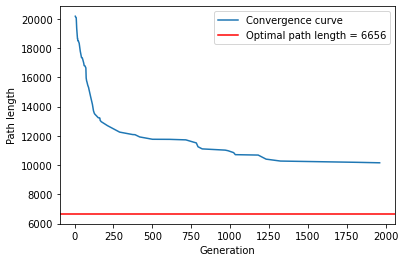

Computational time : 1537.82 s
Minimum path length (result): 10018.7291 
Optimal path length: 6656.0000 
Function evaluations : 19620000
City sequence :
[32. 33. 35. 30. 14. 12. 17. 18. 26. 27. 21. 19. 22. 24. 25. 29. 31. 23.
  5.  2.  4.  6.  7. 37. 36. 34. 28. 20. 13.  9.  0.  1.  3.  8. 15. 16.
 11. 10.]


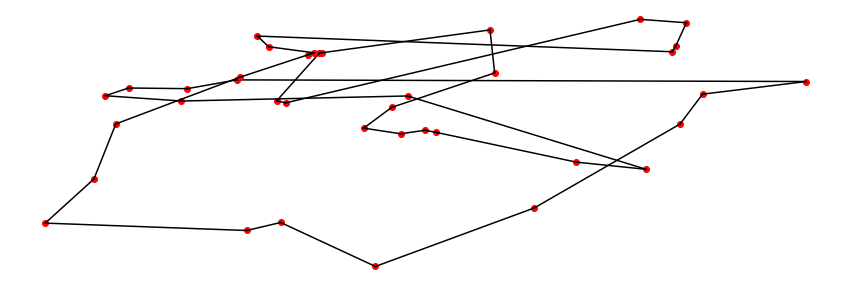

In [10]:
TSP_problem(country=djibcoord, popsize=10000, generations=2000, mut_proba=0.05, optimaldist=6656)

The Genetic Algorithm implemented here achieves a minimum path length of 10018 which is close to the optimal path length of 6656.